In [ ]:
!pip install -q yfinance scikit-learn seaborn pandas_ta --upgrade



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import datetime


def flatten_columns(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [
            "_".join([str(x) for x in tup if str(x) != ""]).rstrip("_")
            for tup in df.columns.values
        ]
    return df


In [ ]:

sp = yf.download(
        "^GSPC",
        start=daily_sent["date"].min(),
        end=datetime.date.today(),
        auto_adjust=False,
        progress=False
     )


print("Columns returned by yfinance:", sp.columns.tolist())


sp = flatten_columns(sp)


close_col_candidates = [c for c in sp.columns if c.lower().startswith("close")]
if not close_col_candidates:
    raise ValueError("Could not find a Close price column in the yfinance data!")
close_col = close_col_candidates[0]   # pick the first match


sp = sp[[close_col]].rename(columns={close_col: "sp_close"})


sp.index = pd.to_datetime(sp.index).tz_localize(None).normalize()


sp_reset = (
    sp.reset_index()
      .rename(columns={"index": "date", "Date": "date"})
)

print("S&P‑500 sample\n", sp_reset.head())


Columns returned by yfinance: [('Adj Close', '^GSPC'), ('Close', '^GSPC'), ('High', '^GSPC'), ('Low', '^GSPC'), ('Open', '^GSPC'), ('Volume', '^GSPC')]
S&P‑500 sample
         date    sp_close
0 2009-02-17  789.169983
1 2009-02-18  788.419983
2 2009-02-19  778.940002
3 2009-02-20  770.049988
4 2009-02-23  743.330017


In [ ]:
merged = pd.merge(daily_sent, sp_reset, on="date", how="inner")


merged["next_close"] = merged["sp_close"].shift(-1)
merged["next_ret"]   = merged["next_close"] / merged["sp_close"] - 1
merged["target_up"]  = (merged["next_ret"] > 0).astype(int)

merged = merged.dropna()
print("Merged data\n", merged.head())


Merged data
         date  mean_score  bullish_pct  bearish_pct  n_articles    sp_close  \
0 2009-04-27         0.0          0.0          0.0           2  857.510010   
1 2009-04-29         0.0          0.0          0.0           1  873.640015   
2 2009-05-22         0.0          0.0          0.0           1  887.000000   
3 2009-05-27         0.5          0.5          0.0           6  893.059998   
4 2009-05-29         0.0          0.0          0.0           2  919.140015   

   next_close  next_ret  target_up  
0  873.640015  0.018810          1  
1  887.000000  0.015292          1  
2  893.059998  0.006832          1  
3  919.140015  0.029203          1  
4  942.869995  0.025818          1  


In [ ]:
features = ["mean_score", "bullish_pct", "bearish_pct", "n_articles"]
X = merged[features].values
y = merged["target_up"].values

tscv = TimeSeriesSplit(n_splits=5)
acc, auc = [], []

for train_idx, test_idx in tscv.split(X):
    model = LogisticRegression(max_iter=1000)
    model.fit(X[train_idx], y[train_idx])

    y_pred = model.predict(X[test_idx])
    y_prob = model.predict_proba(X[test_idx])[:, 1]

    acc.append(accuracy_score(y[test_idx], y_pred))
    auc.append(roc_auc_score(y[test_idx], y_prob))

print(f"Accuracy: {np.mean(acc):.3f} ± {np.std(acc):.3f}")
print(f"AUC:      {np.mean(auc):.3f} ± {np.std(auc):.3f}")


Accuracy: 0.543 ± 0.027
AUC:      0.492 ± 0.025


Loaded 1,407,327 headlines
Daily sentiment features → (348, 7)
        date  mean_score  bullish_pct  bearish_pct  n_articles  \
0 2015-02-03    0.173913     0.391304     0.217391          23   
1 2015-03-30    0.166667     0.291667     0.125000          24   
2 2015-06-29   -0.150000     0.100000     0.250000          20   

   mean_score_roll  bullish_roll  
0         0.293028      0.365492  
1         0.130193      0.244324  
2         0.063527      0.260990  
S&P rows → (2564, 2)
        date     sp_close
0 2015-02-03  2050.030029
1 2015-02-04  2041.510010
2 2015-02-05  2062.520020
Merged final dataset → (341, 12)
        date  mean_score  bullish_pct  bearish_pct  n_articles  \
0 2015-03-30    0.166667     0.291667        0.125          24   
1 2015-06-29   -0.150000     0.100000        0.250          20   
2 2015-07-01    0.300000     0.400000        0.100          20   

   mean_score_roll  bullish_roll     sp_close   next_close  next_ret  \
0         0.130193      0.244324  208

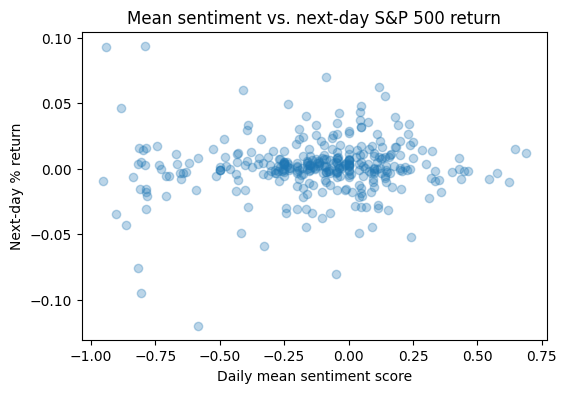

Pearson correlation between mean_score & next_ret: 0.0791
LogReg  Acc : 0.557 ± 0.021
LogReg  AUC : 0.470 ± 0.085
GBM     Acc : 0.457 ± 0.058
GBM     AUC : 0.457 ± 0.077


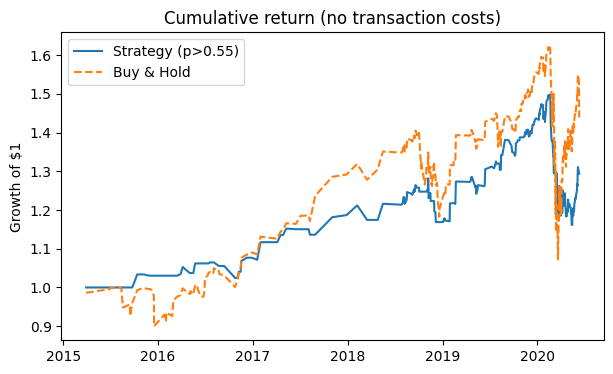

Final Strategy CAGR: 20.98%  (Threshold=0.55)
Buy & Hold     CAGR: 30.86%


In [ ]:

!pip -q install yfinance pytz --upgrade

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit

import datetime, pytz, os

plt.style.use("default")


def flatten_columns(df: pd.DataFrame) -> pd.DataFrame:
    """If a DataFrame has a MultiIndex for columns, collapse it to single level."""
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [
            "_".join([str(x) for x in tup if str(x) != ""]).rstrip("_")
            for tup in df.columns.values
        ]
    return df


DATA_PATH = "/content/labeled_financial_news_2M_clean.csv"
CUTOFF_ET  = "16:00"
MIN_ARTICLES_PER_DAY = 20
ROLLING_WINDOW_DAYS = 3
CUTOFF_THRESHOLD = 0.55



if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"CSV not found at {DATA_PATH}")

news = pd.read_csv(DATA_PATH)
print(f"Loaded {len(news):,} headlines")


required_cols = {"date", "sentiment"}
missing = required_cols - set(news.columns)
if missing:
    raise ValueError(f"Missing required columns in CSV: {missing}")


news["timestamp"] = pd.to_datetime(news["date"], utc=True, errors="coerce")


et = pytz.timezone("US/Eastern")
news["timestamp_et"] = news["timestamp"].dt.tz_convert(et)


cutoff_h, cutoff_m = map(int, CUTOFF_ET.split(":"))
news = news.loc[news["timestamp_et"].dt.time < datetime.time(cutoff_h, cutoff_m)].copy()


sentiment_map = {"bullish": 1, "neutral": 0, "bearish": -1}
news["sent_score"] = news["sentiment"].map(sentiment_map)


news["date"] = news["timestamp_et"].dt.date


agg = (
    news.groupby("date")
    .agg(
        mean_score   = ("sent_score",  "mean"),
        bullish_pct  = ("sentiment",   lambda x: (x == "bullish").mean()),
        bearish_pct  = ("sentiment",   lambda x: (x == "bearish").mean()),
        n_articles   = ("sentiment",   "size"),
    )
    .query("n_articles >= @MIN_ARTICLES_PER_DAY")
)


agg["mean_score_roll"] = agg["mean_score"].rolling(ROLLING_WINDOW_DAYS).mean()
agg["bullish_roll"]    = agg["bullish_pct"].rolling(ROLLING_WINDOW_DAYS).mean()
agg.dropna(inplace=True)


agg = agg.reset_index()
agg["date"] = pd.to_datetime(agg["date"])

print("Daily sentiment features →", agg.shape)
print(agg.head(3))


sp = yf.download(
    "^GSPC",
    start=str(agg["date"].min().date()),
    end=str(datetime.date.today()),
    auto_adjust=False,
    progress=False,
)

sp = flatten_columns(sp)
close_col = [c for c in sp.columns if c.lower().startswith("close")]
if not close_col:
    raise ValueError("Could not find Close column in the yfinance data!")
close_col = close_col[0]

sp = sp[[close_col]].rename(columns={close_col: "sp_close"})
sp.index = pd.to_datetime(sp.index).tz_localize(None)

sp = sp.reset_index().rename(columns={"Date": "date", "index": "date"})

sp["date"] = pd.to_datetime(sp["date"])

print("S&P rows →", sp.shape)
print(sp.head(3))



merged = pd.merge(agg, sp, on="date", how="inner").sort_values("date")

merged["next_close"] = merged["sp_close"].shift(-1)
merged["next_ret"]   = merged["next_close"] / merged["sp_close"] - 1
merged["target_up"]  = (merged["next_ret"] > 0).astype(int)
merged["prev_ret"]   = merged["sp_close"].pct_change()

merged = merged.dropna().reset_index(drop=True)

print("Merged final dataset →", merged.shape)
print(merged.head(3))



plt.figure(figsize=(6,4))
plt.scatter(merged["mean_score"], merged["next_ret"], alpha=0.3)
plt.title("Mean sentiment vs. next‑day S&P 500 return")
plt.xlabel("Daily mean sentiment score")
plt.ylabel("Next‑day % return")
plt.show()

corr_val = merged["mean_score"].corr(merged["next_ret"])
print(f"Pearson correlation between mean_score & next_ret: {corr_val:.4f}")



feature_cols = [
    "mean_score", "bullish_pct", "bearish_pct", "n_articles",
    "mean_score_roll", "bullish_roll", "prev_ret"
]

X = merged[feature_cols].values
y = merged["target_up"].values



from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
metrics = {"logreg_acc": [], "logreg_auc": [], "gb_acc": [], "gb_auc": []}

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    logreg = LogisticRegression(max_iter=2000)
    logreg.fit(X_train, y_train)
    prob_lr = logreg.predict_proba(X_test)[:,1]
    pred_lr = (prob_lr > 0.5).astype(int)
    metrics["logreg_acc"].append(accuracy_score(y_test, pred_lr))
    metrics["logreg_auc"].append(roc_auc_score(y_test, prob_lr))


    gb = GradientBoostingClassifier()
    gb.fit(X_train, y_train)
    prob_gb = gb.predict_proba(X_test)[:,1]
    pred_gb = (prob_gb > 0.5).astype(int)
    metrics["gb_acc"].append(accuracy_score(y_test, pred_gb))
    metrics["gb_auc"].append(roc_auc_score(y_test, prob_gb))

print("LogReg  Acc : %.3f ± %.3f" % (np.mean(metrics["logreg_acc"]), np.std(metrics["logreg_acc"])))
print("LogReg  AUC : %.3f ± %.3f" % (np.mean(metrics["logreg_auc"]), np.std(metrics["logreg_auc"])))
print("GBM     Acc : %.3f ± %.3f" % (np.mean(metrics["gb_acc"]), np.std(metrics["gb_acc"])))
print("GBM     AUC : %.3f ± %.3f" % (np.mean(metrics["gb_auc"]), np.std(metrics["gb_auc"])))



prob_array = np.full(len(merged), np.nan)


for i in range(ROLLING_WINDOW_DAYS*2, len(merged)-1):
    X_train, y_train = X[:i], y[:i]
    X_pred = X[i:i+1]
    model = LogisticRegression(max_iter=2000).fit(X_train, y_train)
    prob_array[i] = model.predict_proba(X_pred)[:,1][0]

merged["prob_up"] = prob_array
merged["position"] = np.where(merged["prob_up"] > CUTOFF_THRESHOLD, 1, 0)
merged["strategy_ret"] = merged["position"] * merged["next_ret"]
merged["cumulative"]   = (1 + merged["strategy_ret"]).cumprod()
merged["buy_hold"]     = (1 + merged["next_ret"]).cumprod()

plt.figure(figsize=(7,4))
plt.plot(merged["date"], merged["cumulative"], label="Strategy (p>%.2f)" % CUTOFF_THRESHOLD)
plt.plot(merged["date"], merged["buy_hold"],    label="Buy & Hold", linestyle="--")
plt.legend()
plt.title("Cumulative return (no transaction costs)")
plt.ylabel("Growth of $1")
plt.show()

final_strat = merged["cumulative"].iloc[-1]
final_bh    = merged["buy_hold"].iloc[-1]
days = len(merged)

strategy_cagr = 100*(final_strat**(252/days) - 1)
bh_cagr       = 100*(final_bh**(252/days) - 1)

print(f"Final Strategy CAGR: {strategy_cagr:.2f}%  (Threshold={CUTOFF_THRESHOLD})")
print(f"Buy & Hold     CAGR: {bh_cagr:.2f}%")

# %% [markdown]
# # Next steps
# - Add transaction costs/spreads in the back‑test.
# - Use more advanced sentiment extraction (FinBERT, GPT, etc.).
# - Try additional features (lagged returns, macro data, etc.).
# - Evaluate out‑of‑sample or in a rolling re‑training to avoid overfitting.
